# Keyword analysis and topic modelling of CB company descriptions

This is an introductory analysis of the company descriptions from the Crunchbase dataset.

(_The dataset can't be provided due to NDA_)

In [2]:
import pandas as pd

# Read the relevant file with the descriptions
orgs = pd.read_csv("organization_descriptions.csv")

# Read descriptions into a list
descriptions = orgs['description'].to_list()

### Basic cleaning of descriptions
Remove null instances and empty strings. Make sure every remaining element is a string.

In [4]:

print(f"Descriptions before cleaning: {len(descriptions)}")

# Remove empty strings and null elements
descriptions = [text for text in descriptions if text != '' and pd.notna(text)]

# Make sure each element is a string
descriptions = [str(text) for text in descriptions]

print(f"Descriptions after cleaning: {len(descriptions)}")

Descriptions before cleaning: 1339449
Descriptions after cleaning: 1339438


## Analysis
1.34 out of 2.8 million organizations in the organiations table come with a description.

### Length distribution
Use spaCy to tokenize the documents and count the tokens of each document. Plot the distributions.


In [45]:
import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")

token_counts = []

# speed up with nlp.pipe for parallel processing
for doc in tqdm(nlp.pipe(descriptions, batch_size=200, n_process=n_process), total=len(descriptions)):
    token_counts.append(len(doc))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1339438/1339438 [41:40<00:00, 535.59it/s]


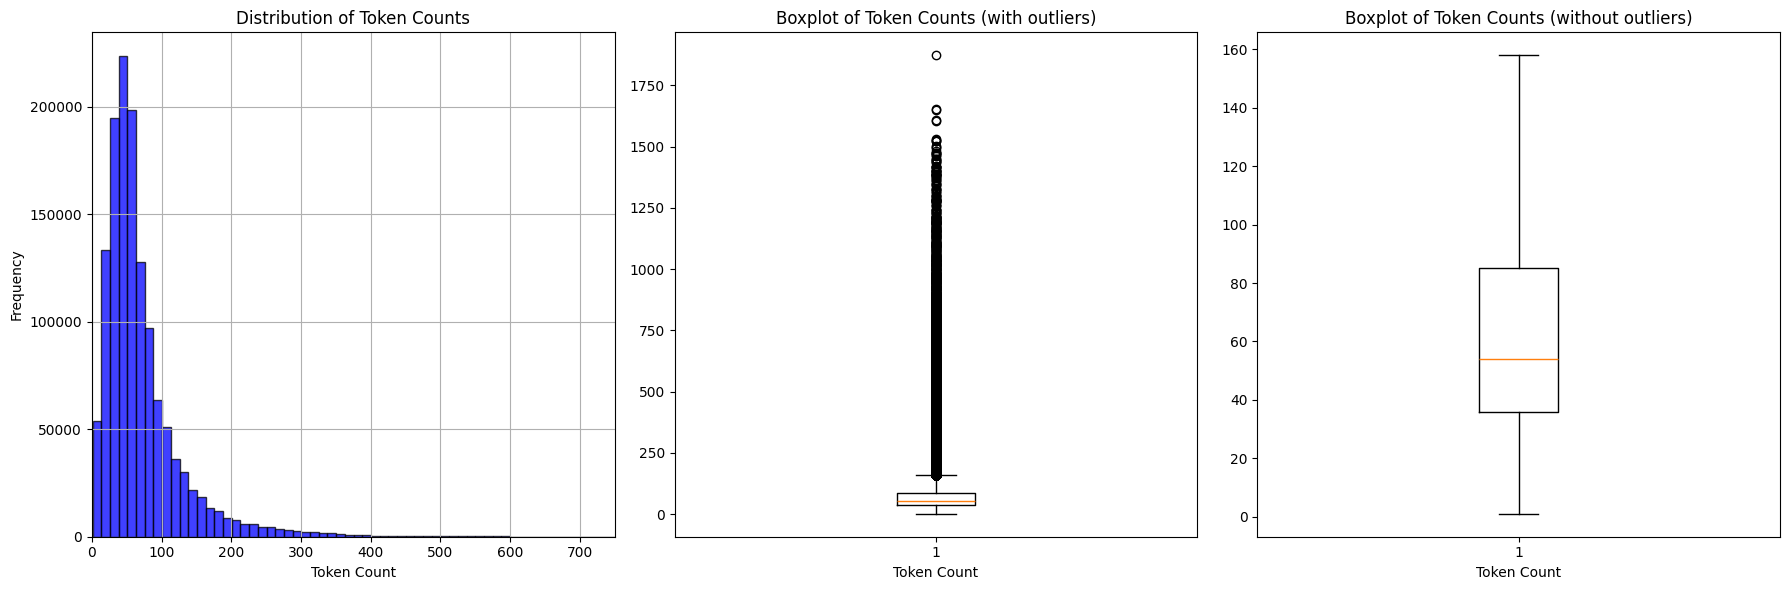

In [46]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogram
axes[0].hist(token_counts, bins=150, alpha=0.75, color='blue', edgecolor='black')
axes[0].set_xlim(left=0, right=750)
axes[0].set_title('Distribution of Token Counts')
axes[0].set_xlabel('Token Count')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# Boxplot with outliers
axes[1].boxplot(token_counts)
axes[1].set_title('Boxplot of Token Counts (with outliers)')
axes[1].set_xlabel('Token Count')

# Boxplot without outliers
axes[2].boxplot(token_counts, showfliers=False)
axes[2].set_title('Boxplot of Token Counts (without outliers)')
axes[2].set_xlabel('Token Count')

# Show the plots
plt.tight_layout()
plt.show()


## KeyBERT for keyword generation

### Single core

In [51]:
# !pip install keybert

from keybert import KeyBERT
from tqdm import tqdm
import pickle

kw_model = KeyBERT()

extracted_keywords = []

for description in tqdm(descriptions):
    keywords = kw_model.extract_keywords(description, keyphrase_ngram_range=(1, 1), stop_words='english')
    extracted_keywords.append(x[0] for x in keywords)

# Save extracted keywords to pickle file
with open("extracted_keywords.pkl", "wb") as f:
    pickle.dump(extracted_keywords, f)

### Keyword analysis

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import pandas as pd

In [13]:
keywords = pd.read_pickle("extracted_keywords.pkl")
descriptions = [' '.join(words) for words in keywords]

In [41]:
def process_keywords(descriptions, stop_words=None, print_top_10=False):
    # Initialize the lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    if stop_words:
        # Lemmatize and filter out stop words
        lemmatized_descriptions = [' '.join([lemmatizer.lemmatize(word) for word in description.split() if lemmatizer.lemmatize(word) not in stop_words]) for description in descriptions]
    else:
        lemmatized_descriptions = [' '.join([lemmatizer.lemmatize(word) for word in description.split()]) for description in descriptions]

    # Vectorize the lemmatized and filtered text data
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(lemmatized_descriptions)
    words = vectorizer.get_feature_names_out()
    
    # Word Frequency Analysis using sparse matrix
    word_freq = np.array(X.sum(axis=0)).flatten()
    word_freq_df = pd.DataFrame({'word': words, 'frequency': word_freq}).sort_values(by='frequency', ascending=False)

    if print_top_10:
        print("Top 10 Words by Frequency:")
        print(word_freq_df.head(10))
    
    return word_freq_df

def generate_word_cloud(word_freq_df):
    # Generate Word Cloud with white background
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(dict(word_freq_df.values))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

Top 10 Words by Frequency:
              word  frequency
515860     service     117775
128363     company      77355
93590     business      50204
357489   marketing      48265
571270  technology      46555
536115    software      45437
294708  investment      32827
131737  consulting      30515
379197      mobile      27860
156891      design      26642


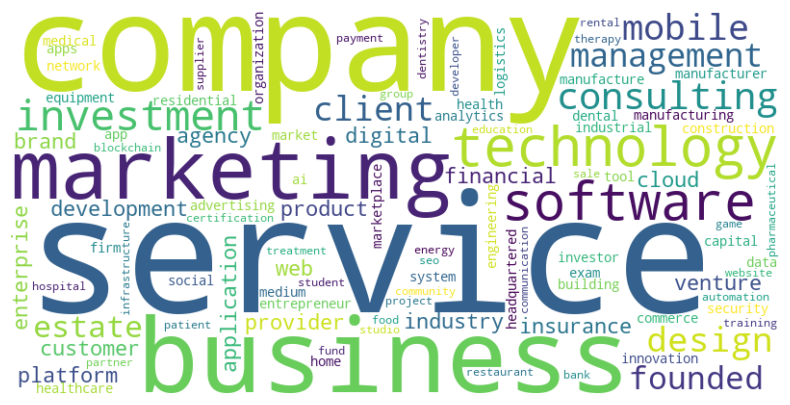

In [54]:

lemmatizer = WordNetLemmatizer()

word_freq_df = process_keywords(descriptions, print_top_10=True)

# Generate word cloud
generate_word_cloud(word_freq_df)

Since the data we're working with is focused on the business domain, there are some anticipated words that aren't very informative for the analysis. We remove some of those words.

Top 10 Words by Frequency (After Removing Domain-Specific Stop Words):
              word  frequency
357487   marketing      48265
571266  technology      46555
536111    software      45437
294706  investment      32827
131735  consulting      30515
379195      mobile      27860
156889      design      26642
120079      client      25226
354931  management      23812
222313     founded      22417


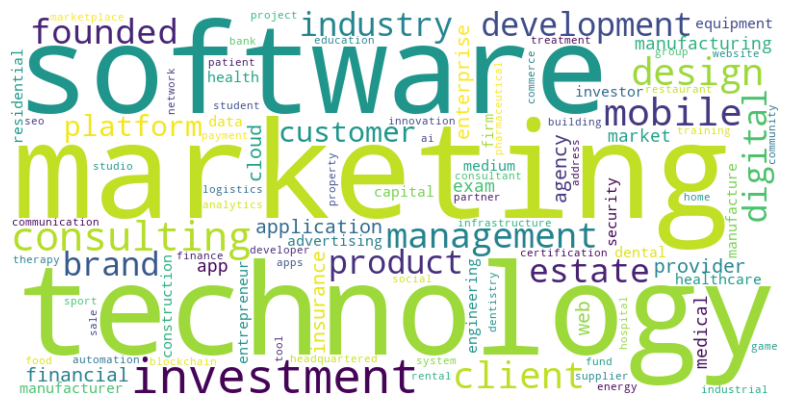

In [50]:
domain_stop_words = ['company', 'business', 'organization', 'venture', 'service']
word_freq_df = process_keywords(descriptions, domain_stop_words, print_top_10=True)

# Generate word cloud
generate_word_cloud(word_freq_df)

# Topic Modelling

In [15]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings using the default BERTopic embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(descriptions, show_progress_bar=True)

Batches:   0%|          | 0/41858 [00:00<?, ?it/s]

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic import BERTopic

# Change default params
umap_model = UMAP(n_neighbors=5, n_components=3, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR (Maximal Marginal Relevance)
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

# Assuming you already have 'embeddings' precomputed from Sentence Transformers

# Create BERTopic instance
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model,
    top_n_words=10,
    verbose=True
)

# Fit and transform using precomputed embeddings
topics, probabilities = topic_model.fit_transform(descriptions, embeddings)

# Show topics
topic_info = topic_model.get_topic_info()
print(topic_info)

with open("bertopic_model.pkl", "wb") as f:
    pickle.dump(topic_model, f)

2024-06-01 20:34:26,358 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


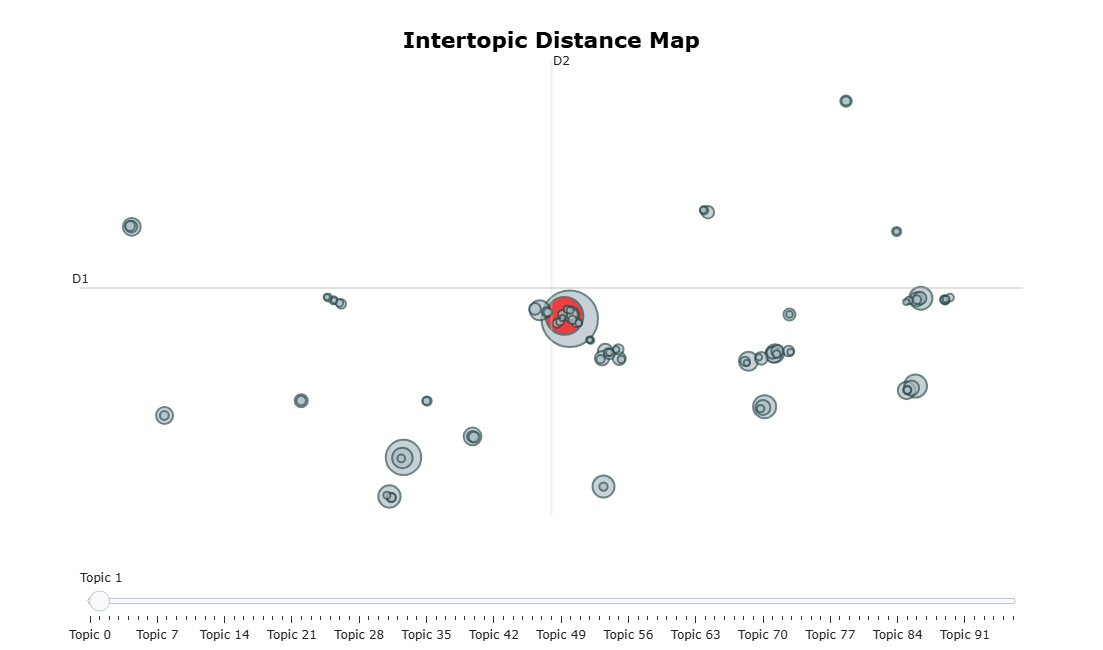

In [31]:
topic_model.visualize_topics()

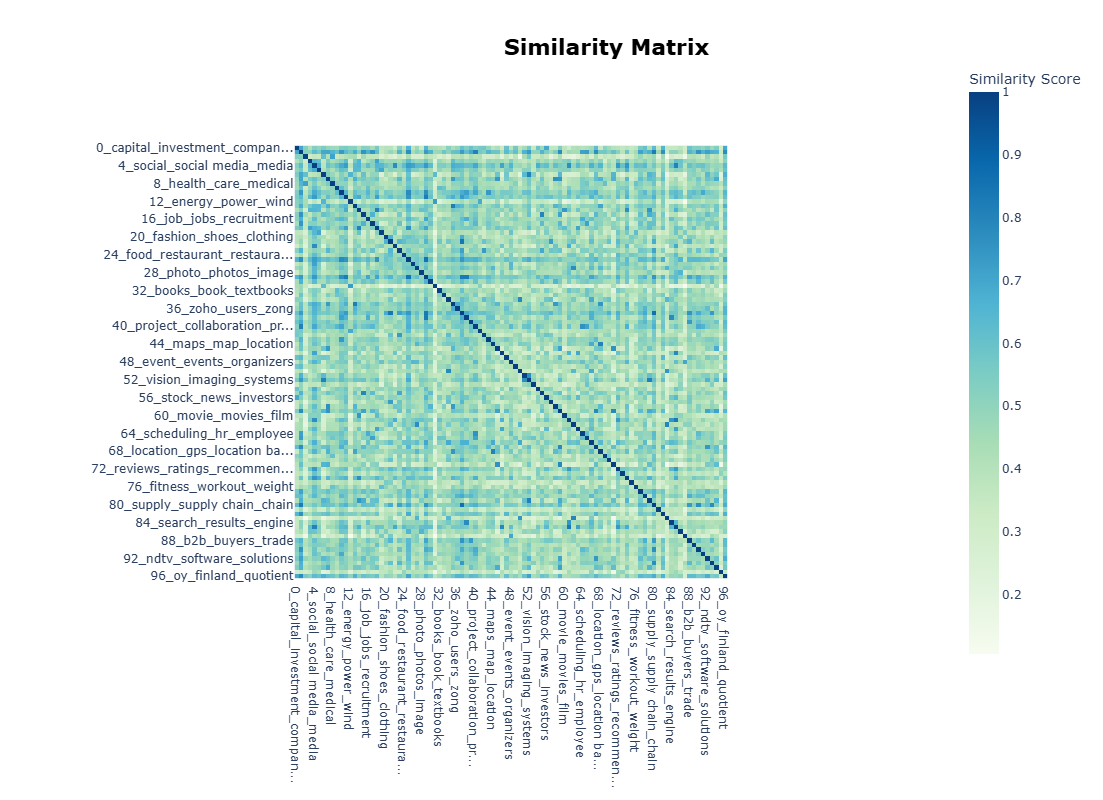

In [86]:
topic_model.visualize_heatmap()

In [ ]:
# with the original embeddings
topic_model.visualize_document_datamap(docs, embeddings=embeddings)

# POS analysis - Verbs

Since our goal is to get to know events that happen in startups/organizations (to later define a set of classes that encompass said events, without relying on ontologies from DBpedia or WikiData), and those events are often described by verbs, it's worth using POS tagging and analyzing the verbs.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from tqdm import tqdm
import pickle

# Use spaCy for POS tagging
nlp = spacy.load("en_core_web_sm")

def extract_verbs(doc):
    verbs = [token.text for token in doc if token.pos_ == "VERB"]
    return " ".join(verbs)

# nlp.pipe for parallel processing
def process_documents(docs, batch_size=1000, n_process=4):
    results = []
    for doc in tqdm(nlp.pipe(docs, batch_size=batch_size, n_process=n_process), total=len(docs)):
        results.append(extract_verbs(doc))
    return results

# Apply the function to text data
processed_descriptions = process_documents(descriptions)

with open("verb_pos.pkl", "wb") as f:
    pickle.dump(processed_descriptions, f)

100%|███████████████████████████████████████████████████████████████████████| 1339438/1339438 [48:52<00:00, 456.81it/s]


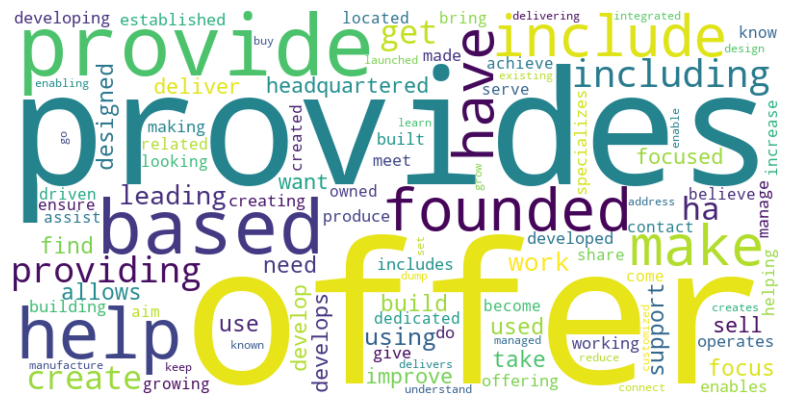

In [52]:
generate_word_cloud(word_freq_df)

**Issue with this approach**: the same verb appears multiple times (provide, provides, provided, ...), so we perform lemmatization to keep only the stem and avoid multiple versions.

In [65]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [71]:
verbs = [string.split(' ') for string in processed_descriptions]
verbs = [verb for sublist in verbs for verb in sublist]

In [78]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

lemmatizer = WordNetLemmatizer()

# Convert NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# POS tagging
pos_tagged_verbs = pos_tag(verbs)

# Lemmatize verbs
lemmatized_verbs = []
for verb, tag in tqdm(pos_tagged_verbs, desc="Lemmatizing verbs"):
    lemmatized_verbs.append(lemmatizer.lemmatize(verb, get_wordnet_pos(tag)))

Lemmatizing verbs: 100%|█████████████████████████████████████████████████| 9326826/9326826 [00:34<00:00, 270307.37it/s]


In [80]:
# Vectorize the lemmatized and filtered text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmatized_verbs)
words = vectorizer.get_feature_names_out()

# Word Frequency Analysis using sparse matrix
word_freq = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': words, 'frequency': word_freq}).sort_values(by='frequency', ascending=False)

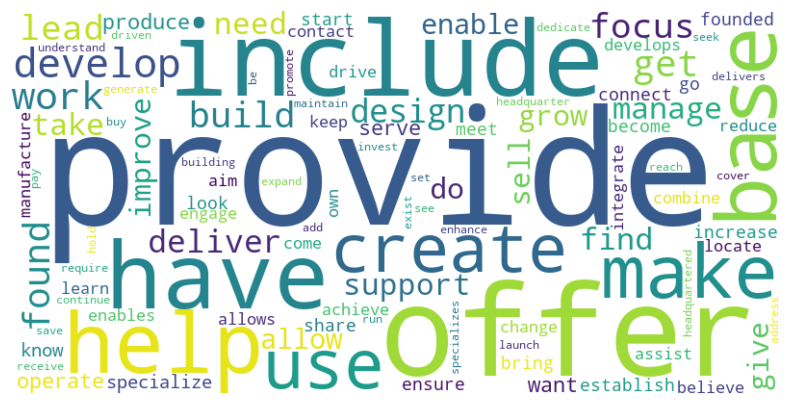

In [81]:
generate_word_cloud(word_freq_df)